In [72]:
%load_ext autoreload
%autoreload 2
from gnnboundary import *
from gnnboundary.datasets.msrc_dataset import MSRCDataset
from lib.gcn_classifier import MultiGCNClassifier
import torch
import numpy as np
import warnings
warnings.warn("out")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_32456/3220367966.py:9: UserWarning: out
  warnings.warn("out")


In [42]:
dataset = MSRCDataset(seed=12345)

Using existing file MSRC_9.zip
Extracting data/MSRC_9/raw/MSRC_9.zip


In [43]:
model = MultiGCNClassifier(node_features=len(dataset.NODE_CLS),
                             num_classes=len(dataset.GRAPH_CLS),
                             hidden_channels=8,
                             num_layers=3)
model.load_state_dict(torch.load('ckpts/msrc_9.pt'))

<All keys matched successfully>

In [44]:
from torchmetrics import F1Score, ConfusionMatrix, Accuracy
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
acc = Accuracy(task="multiclass", num_classes=len(dataset.GRAPH_CLS)).to(device)

for batch in dataset.loader(batch_size=16, shuffle=False):
    acc(model(batch)['logits'].to(device), batch.y.to(device))

x = acc.compute().item()
print(f'accuracy: {x}')

accuracy: 0.9683257937431335


/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [45]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)
print(dataset_list_pred)
print(dataset_list_gt)

[MSRCDataset(14), MSRCDataset(30), MSRCDataset(30), MSRCDataset(30), MSRCDataset(28), MSRCDataset(30), MSRCDataset(29), MSRCDataset(30)]
[MSRCDataset(19), MSRCDataset(30), MSRCDataset(30), MSRCDataset(30), MSRCDataset(23), MSRCDataset(30), MSRCDataset(29), MSRCDataset(30)]


/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage

In [46]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.9683257937431335,
 'cm': array([[13,  0,  0,  0,  6,  0,  0,  0],
        [ 0, 30,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 30,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 30,  0,  0,  0,  0],
        [ 1,  0,  0,  0, 22,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 30,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 29,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 30]]),
 'f1': {'EC1': 0.7878788113594055,
  'EC2': 1.0,
  'EC3': 1.0,
  'EC4': 1.0,
  'EC5': 0.8627451062202454,
  'EC6': 1.0,
  'EC7': 1.0,
  'EC8': 1.0}}

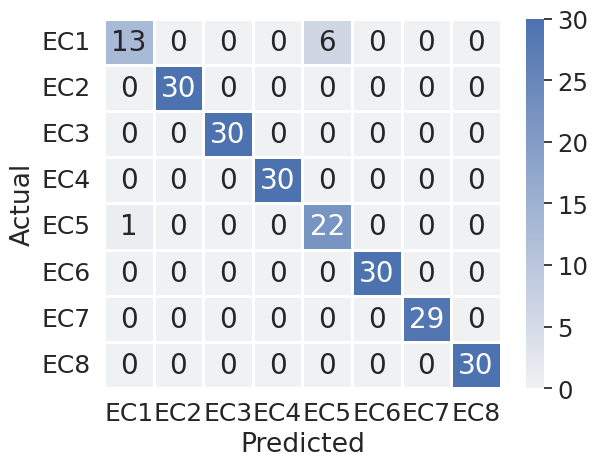

In [47]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [48]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [49]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)

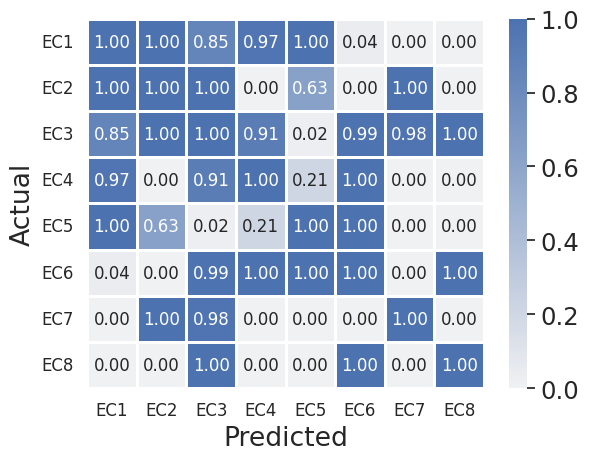

In [50]:
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f', labelsize=12, annotsize=12)

In [51]:
from lib.multi_boundary_analysis import triangular_boundary_analysis

result = triangular_boundary_analysis(model, dataset_list_pred, threshold=0.7)
print(result)

/home/gilian/miniconda3/envs/gnnboundary/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{(0, 1, 2): [0.99, 1.0, 0.89], (0, 2, 3): [0.88, 0.83, 1.0], (1, 2, 6): [1.0, 0.92, 1.0], (2, 3, 5): [0.86, 1.0, 1.0], (2, 5, 7): [1.0, 1.0, 1.0]}


In [113]:
trainer = {}
sampler = {}

from lib.trainer import GPUTrainer

# 0 & 3

In [53]:
cls_1, cls_2 = 0, 3
trainer[cls_1, cls_2] = GPUTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
)

In [54]:
cls_1, cls_2 = 0, 3
trainer[cls_1, cls_2].train(
    iterations=2000,
    target_probs={cls_1: (0.4, 0.6), cls_2: (0.4, 0.6)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

In [74]:
cls_1, cls_2 = 0, 3

trainer[cls_1, cls_2].evaluate(threshold=0.5, show=True, bernoulli=True)

KeyError: (0, 3)

# 0 & 2 & 3

In [119]:
cls_1, cls_2, cls_3 = 0, 2, 3
trainer[cls_1, cls_2, cls_3] = GPUTrainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        temperature=0.2,
        num_node_cls=len(dataset.NODE_CLS),
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
            classes=[cls_1, cls_2, cls_3], alpha=1, beta=1
        ), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_3]), weight=0),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=15, order=2, beta=1),
)

In [120]:
cls_1, cls_2, cls_3 = 0, 2, 3
trainer[cls_1, cls_2, cls_3].train(
    iterations=2000,
    target_probs={cls_3: (0.3, 0.366), cls_2: (0.3, 0.366), cls_3: (0.3, 0.366)},
    target_size=40,
    w_budget_init=1,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

logits=[-2.9228153228759766, -8.86496353149414, -2.430586814880371, -2.2724218368530273, -5.366652488708496, -4.888672828674316, -23.52033805847168, -11.564688682556152]
probs=[0.20912110805511475, 0.0005492318305186927, 0.34211331605911255, 0.4007376730442047, 0.018157368525862694, 0.029284432530403137, 2.3714116781370365e-10, 3.692155587486923e-05]
n=11 m=14


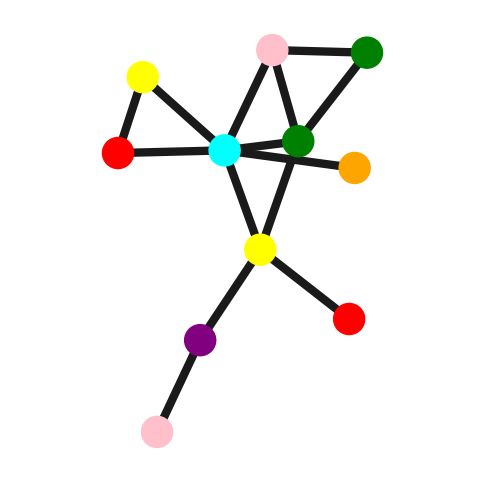

In [121]:
cls_1, cls_2, cls_3 = 0, 2, 3

trainer[cls_1, cls_2, cls_3].evaluate(threshold=0.5, show=True, bernoulli=False)

In [123]:
res = trainer[cls_1, cls_2, cls_3].quantitative(sample_size=500)
print(res["mean"])
print(res["std"])

[5.62144445e-02 5.08847550e-05 9.70159217e-02 6.97043280e-01
 9.01304020e-03 1.40619729e-01 1.38375514e-11 4.27032573e-05]
[7.67615204e-02 1.51359818e-04 1.53318549e-01 2.58507821e-01
 1.26626593e-02 2.11836375e-01 6.01854504e-11 1.97708168e-04]
